In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   

                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l3_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l3_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1523
0
26 32 (1, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1523/1523 [==============================] - 20s 13ms/step - loss: 0.2794 - total_loss: 0.2794 - reg_loss: 0.2794 - val_loss: 0.2631 - val_total_loss: 0.2631 - val_reg_loss: 0.2631
Epoch 2/100
1523/1523 [==============================] - 19s 13ms/step - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938550 -0.009440  0.232266    7  2017-04-16
472     2.507290  2.525125 -0.017834  0.231548    1  2017-04-17
473     2.661330  2.664357 -0.003027  0.252315    2  2017-04-18
474     2.754815  2.734673  0.020142  0.206850    3  2017-04-19
475     2.713762  2.714150 -0.000388  0.234915    4  2017-04-20
476     2.999000  2.948955  0.050045  0.155496    5  2017-04-21
477     3.075529  3.083268 -0.007739  0.184596    6  2017-04-22

0.213998089796
best_epochs [6, 8, 3, 5, 9]
(829, 1) 2.66771818981 

2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 372221 records
valid has 50259 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1521
0
26 32 (2, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1521/1521 [==============================] - 20s 13ms/step - loss: 0.9801 - total_loss: 0.9801 - reg_loss: 0.9801 - val_loss: 0.2710 - val_total_loss: 0.2710 - val_reg_loss: 0.2710
Epoch 2/100
1521/1521 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.941941 -0.012831  0.233405    6  2017-04-15
471     2.507290  2.527209 -0.019918  0.230118    7  2017-04-16
472     2.661330  2.671951 -0.010621  0.243634    1  2017-04-17
473     2.754815  2.738954  0.015861  0.214875    2  2017-04-18
474     2.713762  2.712676  0.001085  0.236706    3  2017-04-19
475     2.999000  2.991204  0.007796  0.156349    4  2017-04-20
476     3.075529  3.076560 -0.001031  0.183570    5  2017-04-21

0.2140938267
best_epochs [7, 3, 6, 5, 4]
(829, 1) 2.5059962862 

3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 372221 records
valid has 50216 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1520
0
26 32 (3, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1520/1520 [==============================] - 21s 14ms/step - loss: 0.2936 - total_loss: 0.2936 - reg_loss: 0.2936 - val_loss: 0.2744 - val_total_loss: 0.2744 - val_reg_loss: 0.2744
Epoch 2/100
1520/1520 [==============================] - 20s 13ms/step - l

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.914583  0.014527  0.237332    5  2017-04-14
470     2.507290  2.515150 -0.007859  0.229230    6  2017-04-15
471     2.661330  2.659894  0.001435  0.259747    7  2017-04-16
472     2.754815  2.758688 -0.003873  0.207704    1  2017-04-17
473     2.713762  2.726254 -0.012492  0.235915    2  2017-04-18
474     2.999000  2.998825  0.000175  0.155538    3  2017-04-19
475     3.075529  3.063617  0.011912  0.184103    4  2017-04-20

0.215652539949
best_epochs [7, 5, 8, 4, 3]
(829, 1) 2.63346954811 

4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194392, 2) (50166, 2)
train/valid # (194392, 2) (50166, 2)
rand split across time
train has 194392 records out of 372221 records
valid has 50166 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1518
0
26 32 (4, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1518/1518 [==============================] - 21s 14ms/step - loss: 0.2984 - total_loss: 0.2984 - reg_loss: 0.2984 - val_loss: 0.2707 - val_total_loss: 0.2707 - val_reg_loss: 0.2707
Epoch 2/100
1518/1518 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.909048  0.020061  0.242601    4  2017-04-13
469     2.507290  2.516560 -0.009270  0.236605    5  2017-04-14
470     2.661330  2.640612  0.020717  0.256535    6  2017-04-15
471     2.754815  2.761162 -0.006348  0.210412    7  2017-04-16
472     2.713762  2.715399 -0.001638  0.234361    1  2017-04-17
473     2.999000  2.979133  0.019867  0.159571    2  2017-04-18
474     3.075529  3.072276  0.003253  0.178975    3  2017-04-19

0.217008629525
best_epochs [6, 8, 3, 10, 4]
(829, 1) 2.71596955976 

5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194176, 2) (50111, 2)
train/valid # (194176, 2) (50111, 2)
rand split across time
train has 194176 records out of 372221 records
valid has 50111 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1517
0
26 32 (5, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1517/1517 [==============================] - 20s 14ms/step - loss: 0.2971 - total_loss: 0.2971 - reg_loss: 0.2971 - val_loss: 0.2735 - val_total_loss: 0.2735 - val_reg_loss: 0.2735
Epoch 2/100
1517/1517 [==============================] - 20s 13ms/step

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.941630 -0.012520  0.233689    3  2017-04-12
468     2.507290  2.546666 -0.039376  0.235928    4  2017-04-13
469     2.661330  2.633814  0.027516  0.256787    5  2017-04-14
470     2.754815  2.741616  0.013198  0.204832    6  2017-04-15
471     2.713762  2.742453 -0.028691  0.234805    7  2017-04-16
472     2.999000  2.995794  0.003205  0.154833    1  2017-04-17
473     3.075529  3.093383 -0.017854  0.184204    2  2017-04-18

0.215011139811
best_epochs [5, 4, 8, 6, 10]
(829, 1) 2.76202516039 

6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 15.1334
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 372221 records
valid has 50055 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1515
0
26 32 (6, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1515/1515 [==============================] - 20s 13ms/step - loss: 0.2999 - total_loss: 0.2999 - reg_loss: 0.2999 - val_loss: 0.2714 - val_total_loss: 0.2714 - val_reg_loss: 0.2714
Epoch 2/100
1515/1515 [==============================] - 19s 13ms/step

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.927873  0.001237  0.244802    2  2017-04-11
467     2.507290  2.541295 -0.034005  0.247931    3  2017-04-12
468     2.661330  2.656261  0.005069  0.266438    4  2017-04-13
469     2.754815  2.737833  0.016981  0.217392    5  2017-04-14
470     2.713762  2.744660 -0.030898  0.246630    6  2017-04-15
471     2.999000  2.996153  0.002847  0.161495    7  2017-04-16
472     3.075529  3.081333 -0.005804  0.187060    1  2017-04-17

0.224535387647
best_epochs [2, 5, 4, 1, 6]
(829, 1) 3.04654719161 

7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 16.3101
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 372221 records
valid has 49997 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1513
0
26 32 (7, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1513/1513 [==============================] - 20s 13ms/step - loss: 0.3031 - total_loss: 0.3031 - reg_loss: 0.3031 - val_loss: 0.2887 - val_total_loss: 0.2887 - val_reg_loss: 0.2887
Epoch 2/100
1513/1513 [==============================] - 19s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.899207  0.029903  0.237993    1  2017-04-10
466     2.507290  2.531730 -0.024439  0.243479    2  2017-04-11
467     2.661330  2.656988  0.004342  0.262836    3  2017-04-12
468     2.754815  2.722844  0.031971  0.219256    4  2017-04-13
469     2.713762  2.723239 -0.009477  0.243744    5  2017-04-14
470     2.999000  2.980130  0.018870  0.162154    6  2017-04-15
471     3.075529  3.085468 -0.009938  0.182522    7  2017-04-16

0.221711983812
best_epochs [6, 5, 8, 4, 7]
(829, 1) 3.02843619382 

8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 17.5743
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 372221 records
valid has 49937 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1511
0
26 32 (8, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1511/1511 [==============================] - 20s 13ms/step - loss: 0.3050 - total_loss: 0.3050 - reg_loss: 0.3050 - val_loss: 0.2757 - val_total_loss: 0.2757 - val_reg_loss: 0.2757
Epoch 2/100
1511/1511 [==============================] - 19s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.897536  0.031574  0.242358    7  2017-04-09
465     2.507290  2.506182  0.001108  0.238092    1  2017-04-10
466     2.661330  2.640482  0.020847  0.270531    2  2017-04-11
467     2.754815  2.716138  0.038677  0.223490    3  2017-04-12
468     2.713762  2.726041 -0.012280  0.246549    4  2017-04-13
469     2.999000  2.993024  0.005975  0.164605    5  2017-04-14
470     3.075529  3.096989 -0.021460  0.188506    6  2017-04-15

0.224875870602
best_epochs [4, 7, 2, 6, 9]
(829, 1) 2.73470580939 

9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 18.8065
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 372221 records
valid has 49879 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1510
0
26 32 (9, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1510/1510 [==============================] - 20s 13ms/step - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056 - val_loss: 0.3236 - val_total_loss: 0.3236 - val_reg_loss: 0.3236
Epoch 2/100
1510/1510 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.929907 -0.000797  0.254633    6  2017-04-08
464     2.507290  2.546078 -0.038788  0.244480    7  2017-04-09
465     2.661330  2.672831 -0.011501  0.273423    1  2017-04-10
466     2.754815  2.727323  0.027491  0.228533    2  2017-04-11
467     2.713762  2.706416  0.007345  0.245486    3  2017-04-12
468     2.999000  2.975090  0.023909  0.166625    4  2017-04-13
469     3.075529  3.081338 -0.005809  0.188883    5  2017-04-14

0.228866025757
best_epochs [4, 6, 8, 3, 7]
(829, 1) 2.56274111628 

10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 19.9265
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 372221 records
valid has 49836 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1508
0
26 32 (10, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1508/1508 [==============================] - 20s 13ms/step - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080 - val_loss: 0.2853 - val_total_loss: 0.2853 - val_reg_loss: 0.2853
Epoch 2/100
1508/1508 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.942271 -0.013161  0.251795    5  2017-04-07
463     2.507290  2.536567 -0.029276  0.243483    6  2017-04-08
464     2.661330  2.652344  0.008985  0.278067    7  2017-04-09
465     2.754815  2.743752  0.011063  0.226394    1  2017-04-10
466     2.713762  2.710299  0.003463  0.248884    2  2017-04-11
467     2.999000  2.975858  0.023142  0.171598    3  2017-04-12
468     3.075529  3.117325 -0.041796  0.191963    4  2017-04-13

0.230312011681
best_epochs [4, 6, 7, 5, 2]
(829, 1) 2.66942679811 

11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 21.0577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 372221 records
valid has 49783 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1507
0
26 32 (11, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1507/1507 [==============================] - 20s 13ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.2808 - val_total_loss: 0.2808 - val_reg_loss: 0.2808
Epoch 2/100
1507/1507 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.932646 -0.003536  0.249362    4  2017-04-06
462     2.507290  2.550711 -0.043420  0.243329    5  2017-04-07
463     2.661330  2.686417 -0.025087  0.272036    6  2017-04-08
464     2.754815  2.738446  0.016369  0.222072    7  2017-04-09
465     2.713762  2.745161 -0.031400  0.243455    1  2017-04-10
466     2.999000  2.998117  0.000883  0.167975    2  2017-04-11
467     3.075529  3.092284 -0.016755  0.188618    3  2017-04-12

0.226692273267
best_epochs [5, 4, 3, 8, 7]
(829, 1) 3.01496217569 

12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 22.1151
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 372221 records
valid has 49727 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1505
0
26 32 (12, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1505/1505 [==============================] - 20s 13ms/step - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134 - val_loss: 0.2845 - val_total_loss: 0.2845 - val_reg_loss: 0.2845
Epoch 2/100
1505/1505 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.887400  0.041709  0.253097    3  2017-04-05
461     2.507290  2.511878 -0.004588  0.246111    4  2017-04-06
462     2.661330  2.649334  0.011996  0.278551    5  2017-04-07
463     2.754815  2.735271  0.019544  0.230235    6  2017-04-08
464     2.713762  2.721510 -0.007748  0.244938    7  2017-04-09
465     2.999000  2.981306  0.017693  0.168555    1  2017-04-10
466     3.075529  3.065404  0.010125  0.191845    2  2017-04-11

0.230475948778
best_epochs [5, 6, 4, 7, 3]
(829, 1) 3.02881568594 

13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 23.1552
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 372221 records
valid has 49671 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1503
0
26 32 (13, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1503/1503 [==============================] - 20s 13ms/step - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173 - val_loss: 0.2936 - val_total_loss: 0.2936 - val_reg_loss: 0.2936
Epoch 2/100
1503/1503 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.920154  0.008956  0.253274    2  2017-04-04
460     2.507290  2.506979  0.000312  0.246653    3  2017-04-05
461     2.661330  2.659452  0.001877  0.279116    4  2017-04-06
462     2.754815  2.722791  0.032024  0.232878    5  2017-04-07
463     2.713762  2.710527  0.003234  0.249658    6  2017-04-08
464     2.999000  2.964416  0.034583  0.167759    7  2017-04-09
465     3.075529  3.046145  0.029384  0.189673    1  2017-04-10

0.231287169621
best_epochs [5, 7, 4, 8, 3]
(829, 1) 3.01208158833 

14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 24.2264
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 372221 records
valid has 49617 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1502
0
26 32 (14, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1502/1502 [==============================] - 20s 13ms/step - loss: 0.3172 - total_loss: 0.3172 - reg_loss: 0.3172 - val_loss: 0.2907 - val_total_loss: 0.2907 - val_reg_loss: 0.2907
Epoch 2/100
1502/1502 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.908709  0.020400  0.245326    1  2017-04-03
459     2.507290  2.524046 -0.016756  0.241014    2  2017-04-04
460     2.661330  2.657961  0.003369  0.275001    3  2017-04-05
461     2.754815  2.716287  0.038528  0.230250    4  2017-04-06
462     2.713762  2.718142 -0.004380  0.246569    5  2017-04-07
463     2.999000  2.976549  0.022451  0.161681    6  2017-04-08
464     3.075529  3.090170 -0.014641  0.190420    7  2017-04-09

0.227180023896
best_epochs [6, 7, 8, 5, 3]
(829, 1) 3.09149565362 

15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 25.3577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 372221 records
valid has 49559 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1500
0
26 32 (15, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189 - val_loss: 0.3231 - val_total_loss: 0.3231 - val_reg_loss: 0.3231
Epoch 2/100
1500/1500 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.943853 -0.014743  0.261573    7  2017-04-02
458     2.507290  2.556763 -0.049472  0.249944    1  2017-04-03
459     2.661330  2.678360 -0.017030  0.284270    2  2017-04-04
460     2.754815  2.744753  0.010062  0.229433    3  2017-04-05
461     2.713762  2.756572 -0.042810  0.261202    4  2017-04-06
462     2.999000  3.027419 -0.028419  0.173151    5  2017-04-07
463     3.075529  3.077504 -0.001975  0.194419    6  2017-04-08

0.236284503473
best_epochs [4, 5, 3, 2, 7]
(829, 1) 2.7657011598 

16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 26.4659
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 372221 records
valid has 49500 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1498
0
26 32 (16, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1498/1498 [==============================] - 19s 13ms/step - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189 - val_loss: 0.3024 - val_total_loss: 0.3024 - val_reg_loss: 0.3024
Epoch 2/100
1498/1498 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.889880  0.039230  0.267644    6  2017-04-01
457     2.507290  2.504830  0.002461  0.241948    7  2017-04-02
458     2.661330  2.624117  0.037213  0.281303    1  2017-04-03
459     2.754815  2.685023  0.069792  0.238175    2  2017-04-04
460     2.713762  2.678067  0.035695  0.250441    3  2017-04-05
461     2.999000  2.938847  0.060153  0.173312    4  2017-04-06
462     3.075529  3.021748  0.053781  0.195659    5  2017-04-07

0.235497497117
best_epochs [3, 4, 5, 8, 6]
(829, 1) 2.52853227868 

17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 27.6058
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 372221 records
valid has 49458 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1497
0
26 32 (17, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1497/1497 [==============================] - 19s 13ms/step - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230 - val_loss: 0.3116 - val_total_loss: 0.3116 - val_reg_loss: 0.3116
Epoch 2/100
1497/1497 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.979582 -0.050472  0.268092    5  2017-03-31
456     2.507290  2.553241 -0.045951  0.251425    6  2017-04-01
457     2.661330  2.685051 -0.023721  0.279828    7  2017-04-02
458     2.754815  2.713672  0.041143  0.242322    1  2017-04-03
459     2.713762  2.749325 -0.035563  0.257008    2  2017-04-04
460     2.999000  3.002845 -0.003846  0.171821    3  2017-04-05
461     3.075529  3.095520 -0.019991  0.192556    4  2017-04-06

0.237578890464
best_epochs [5, 3, 4, 6, 9]
(829, 1) 2.70127246399 

18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 28.7513
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 372221 records
valid has 49407 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1495
0
26 32 (18, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1495/1495 [==============================] - 20s 13ms/step - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258 - val_loss: 0.2917 - val_total_loss: 0.2917 - val_reg_loss: 0.2917
Epoch 2/100
1495/1495 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.899456  0.029654  0.267348    4  2017-03-30
455     2.507290  2.507491 -0.000200  0.250139    5  2017-03-31
456     2.661330  2.634193  0.027137  0.281544    6  2017-04-01
457     2.754815  2.713924  0.040891  0.235565    7  2017-04-02
458     2.713762  2.698700  0.015061  0.255220    1  2017-04-03
459     2.999000  2.963317  0.035683  0.177918    2  2017-04-04
460     3.075529  3.033516  0.042013  0.197273    3  2017-04-05

0.237858033353
best_epochs [5, 3, 6, 7, 1]
(829, 1) 2.74639734828 

19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 29.7986
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191251, 2) (49352, 2)
train/valid # (191251, 2) (49352, 2)
rand split across time
train has 191251 records out of 372221 records
valid has 49352 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1494
0
26 32 (19, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1494/1494 [==============================] - 20s 13ms/step - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264 - val_loss: 0.2973 - val_total_loss: 0.2973 - val_reg_loss: 0.2973
Epoch 2/100
1494/1494 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.954497 -0.025387  0.267445    3  2017-03-29
454     2.507290  2.528227 -0.020937  0.251825    4  2017-03-30
455     2.661330  2.636249  0.025081  0.284188    5  2017-03-31
456     2.754815  2.715413  0.039401  0.241003    6  2017-04-01
457     2.713762  2.720063 -0.006302  0.254937    7  2017-04-02
458     2.999000  3.005275 -0.006276  0.173640    1  2017-04-03
459     3.075529  3.085017 -0.009488  0.200505    2  2017-04-04

0.239077576341
best_epochs [3, 5, 4, 7, 8]
(829, 1) 2.73196301658 

20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 30.7963
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191040, 2) (49296, 2)
train/valid # (191040, 2) (49296, 2)
rand split across time
train has 191040 records out of 372221 records
valid has 49296 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1492
0
26 32 (20, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1492/1492 [==============================] - 19s 13ms/step - loss: 0.3214 - total_loss: 0.3214 - reg_loss: 0.3214 - val_loss: 0.3213 - val_total_loss: 0.3213 - val_reg_loss: 0.3213
Epoch 2/100
1492/1492 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.939003 -0.009893  0.256310    2  2017-03-28
453     2.507290  2.553922 -0.046632  0.249269    3  2017-03-29
454     2.661330  2.648878  0.012451  0.281762    4  2017-03-30
455     2.754815  2.708198  0.046617  0.240732    5  2017-03-31
456     2.713762  2.712007  0.001754  0.264487    6  2017-04-01
457     2.999000  2.979756  0.019244  0.173780    7  2017-04-02
458     3.075529  3.053138  0.022391  0.195388    1  2017-04-03

0.237389560882
best_epochs [7, 3, 5, 6, 4]
(829, 1) 2.96807112827 

21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 31.7929
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190828, 2) (49240, 2)
train/valid # (190828, 2) (49240, 2)
rand split across time
train has 190828 records out of 372221 records
valid has 49240 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1490
0
26 32 (21, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1490/1490 [==============================] - 19s 13ms/step - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301 - val_loss: 0.3009 - val_total_loss: 0.3009 - val_reg_loss: 0.3009
Epoch 2/100
1490/1490 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.906790  0.022320  0.266741    1  2017-03-27
452     2.507290  2.540214 -0.032923  0.249419    2  2017-03-28
453     2.661330  2.625064  0.036265  0.281811    3  2017-03-29
454     2.754815  2.698650  0.056164  0.239197    4  2017-03-30
455     2.713762  2.694008  0.019754  0.257782    5  2017-03-31
456     2.999000  2.968561  0.030439  0.185654    6  2017-04-01
457     3.075529  3.069809  0.005720  0.195216    7  2017-04-02

0.239402871911
best_epochs [4, 7, 5, 8, 6]
(829, 1) 3.04362905739 

22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 32.871
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190598, 2) (49181, 2)
train/valid # (190598, 2) (49181, 2)
rand split across time
train has 190598 records out of 372221 records
valid has 49181 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1489
0
26 32 (22, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1489/1489 [==============================] - 19s 13ms/step - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302 - val_loss: 0.3007 - val_total_loss: 0.3007 - val_reg_loss: 0.3007
Epoch 2/100
1489/1489 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.882162  0.046948  0.271760    7  2017-03-26
451     2.507290  2.511660 -0.004369  0.256078    1  2017-03-27
452     2.661330  2.629639  0.031691  0.287416    2  2017-03-28
453     2.754815  2.699606  0.055208  0.244907    3  2017-03-29
454     2.713762  2.683002  0.030760  0.273539    4  2017-03-30
455     2.999000  2.900950  0.098050  0.193760    5  2017-03-31
456     3.075529  3.028165  0.047364  0.200650    6  2017-04-01

0.246872900548
best_epochs [4, 3, 2, 6, 5]
(829, 1) 2.71116888116 

23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 33.9745
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190367, 2) (49122, 2)
train/valid # (190367, 2) (49122, 2)
rand split across time
train has 190367 records out of 372221 records
valid has 49122 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1487
0
26 32 (23, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1487/1487 [==============================] - 19s 13ms/step - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322 - val_loss: 0.3108 - val_total_loss: 0.3108 - val_reg_loss: 0.3108
Epoch 2/100
1487/1487 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.935828 -0.006718  0.266606    6  2017-03-25
450     2.507290  2.557462 -0.050171  0.254967    7  2017-03-26
451     2.661330  2.671581 -0.010251  0.275977    1  2017-03-27
452     2.754815  2.742383  0.012432  0.240000    2  2017-03-28
453     2.713762  2.727736 -0.013974  0.266426    3  2017-03-29
454     2.999000  2.982162  0.016838  0.183426    4  2017-03-30
455     3.075529  3.073438  0.002092  0.195843    5  2017-03-31

0.240463674278
best_epochs [3, 7, 2, 5, 6]
(829, 1) 2.49929615146 

24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 35.2084
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190195, 2) (49080, 2)
train/valid # (190195, 2) (49080, 2)
rand split across time
train has 190195 records out of 372221 records
valid has 49080 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1485
0
26 32 (24, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1485/1485 [==============================] - 19s 13ms/step - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309 - val_loss: 0.3026 - val_total_loss: 0.3026 - val_reg_loss: 0.3026
Epoch 2/100
1485/1485 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.941450 -0.012341  0.266060    5  2017-03-24
449     2.507290  2.519457 -0.012167  0.253116    6  2017-03-25
450     2.661330  2.666082 -0.004753  0.281517    7  2017-03-26
451     2.754815  2.738469  0.016346  0.238232    1  2017-03-27
452     2.713762  2.736514 -0.022752  0.266857    2  2017-03-28
453     2.999000  2.970669  0.028331  0.183302    3  2017-03-29
454     3.075529  3.044077  0.031452  0.198966    4  2017-03-30

0.241150069126
best_epochs [4, 7, 8, 2, 5]
(829, 1) 2.5844013508 

25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 36.3351
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190017, 2) (49031, 2)
train/valid # (190017, 2) (49031, 2)
rand split across time
train has 190017 records out of 372221 records
valid has 49031 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1484
0
26 32 (25, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1484/1484 [==============================] - 18s 12ms/step - loss: 0.3305 - total_loss: 0.3305 - reg_loss: 0.3305 - val_loss: 0.3141 - val_total_loss: 0.3141 - val_reg_loss: 0.3141
Epoch 2/100
1484/1484 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.891500  0.037610  0.269986    4  2017-03-23
448     2.507290  2.471542  0.035749  0.257315    5  2017-03-24
449     2.661330  2.640697  0.020633  0.282792    6  2017-03-25
450     2.754815  2.727361  0.027453  0.242578    7  2017-03-26
451     2.713762  2.676893  0.036869  0.267378    1  2017-03-27
452     2.999000  2.957958  0.041042  0.182061    2  2017-03-28
453     3.075529  3.034545  0.040984  0.201137    3  2017-03-29

0.243321002558
best_epochs [5, 3, 7, 4, 6]
(829, 1) 2.68332564131 

26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 37.3741
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189807, 2) (48977, 2)
train/valid # (189807, 2) (48977, 2)
rand split across time
train has 189807 records out of 372221 records
valid has 48977 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1482
0
26 32 (26, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1482/1482 [==============================] - 19s 13ms/step - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334 - val_loss: 0.3011 - val_total_loss: 0.3011 - val_reg_loss: 0.3011
Epoch 2/100
1482/1482 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.915358  0.013752  0.279187    3  2017-03-22
447     2.507290  2.539601 -0.032310  0.253803    4  2017-03-23
448     2.661330  2.655417  0.005913  0.281876    5  2017-03-24
449     2.754815  2.703222  0.051592  0.245251    6  2017-03-25
450     2.713762  2.674198  0.039564  0.266939    7  2017-03-26
451     2.999000  2.943081  0.055919  0.184272    1  2017-03-27
452     3.075529  3.055494  0.020035  0.202669    2  2017-03-28

0.244856635691
best_epochs [5, 6, 3, 4, 8]
(829, 1) 2.71095179047 

27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 38.4506
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189587, 2) (48924, 2)
train/valid # (189587, 2) (48924, 2)
rand split across time
train has 189587 records out of 372221 records
valid has 48924 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1481
0
26 32 (27, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1481/1481 [==============================] - 19s 13ms/step - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346 - val_loss: 0.3158 - val_total_loss: 0.3158 - val_reg_loss: 0.3158
Epoch 2/100
1481/1481 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.875941  0.053169  0.273500    2  2017-03-21
446     2.507290  2.512191 -0.004901  0.256740    3  2017-03-22
447     2.661330  2.646189  0.015141  0.280071    4  2017-03-23
448     2.754815  2.721943  0.032872  0.241651    5  2017-03-24
449     2.713762  2.713873 -0.000112  0.266398    6  2017-03-25
450     2.999000  2.965435  0.033565  0.184986    7  2017-03-26
451     3.075529  3.057655  0.017874  0.197333    1  2017-03-27

0.242954295574
best_epochs [4, 3, 6, 5, 7]
(829, 1) 3.02607783544 

28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 39.4798
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189367, 2) (48864, 2)
train/valid # (189367, 2) (48864, 2)
rand split across time
train has 189367 records out of 372221 records
valid has 48864 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1479
0
26 32 (28, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1479/1479 [==============================] - 20s 13ms/step - loss: 0.3334 - total_loss: 0.3334 - reg_loss: 0.3334 - val_loss: 0.3088 - val_total_loss: 0.3088 - val_reg_loss: 0.3088
Epoch 2/100
1479/1479 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.942917 -0.013807  0.270431    1  2017-03-20
445     2.507290  2.494284  0.013007  0.256184    2  2017-03-21
446     2.661330  2.652819  0.008511  0.278547    3  2017-03-22
447     2.754815  2.720447  0.034368  0.242440    4  2017-03-23
448     2.713762  2.702246  0.011516  0.267330    5  2017-03-24
449     2.999000  2.978101  0.020899  0.181761    6  2017-03-25
450     3.075529  3.094984 -0.019455  0.203337    7  2017-03-26

0.242861416712
best_epochs [3, 6, 5, 7, 8]
(829, 1) 3.09181427519 

29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 40.7934
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189133, 2) (48803, 2)
train/valid # (189133, 2) (48803, 2)
rand split across time
train has 189133 records out of 372221 records
valid has 48803 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1477
0
26 32 (29, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1477/1477 [==============================] - 20s 13ms/step - loss: 0.3766 - total_loss: 0.3766 - reg_loss: 0.3766 - val_loss: 0.3152 - val_total_loss: 0.3152 - val_reg_loss: 0.3152
Epoch 2/100
1477/1477 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.946745 -0.017635  0.270531    7  2017-03-19
444     2.507290  2.492192  0.015098  0.257436    1  2017-03-20
445     2.661330  2.653541  0.007789  0.280183    2  2017-03-21
446     2.754815  2.733323  0.021492  0.247884    3  2017-03-22
447     2.713762  2.716523 -0.002761  0.266181    4  2017-03-23
448     2.999000  2.980290  0.018710  0.180802    5  2017-03-24
449     3.075529  3.065381  0.010148  0.204389    6  2017-03-25

0.24391525351
best_epochs [2, 4, 5, 7, 6]
(829, 1) 2.81462139106 

30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 41.9859
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188902, 2) (48743, 2)
train/valid # (188902, 2) (48743, 2)
rand split across time
train has 188902 records out of 372221 records
valid has 48743 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1475
0
26 32 (30, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1475/1475 [==============================] - 19s 13ms/step - loss: 0.3448 - total_loss: 0.3448 - reg_loss: 0.3448 - val_loss: 0.3224 - val_total_loss: 0.3224 - val_reg_loss: 0.3224
Epoch 2/100
1475/1475 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.906779  0.022331  0.274438    6  2017-03-18
443     2.507290  2.544332 -0.037041  0.252562    7  2017-03-19
444     2.661330  2.664201 -0.002872  0.286867    1  2017-03-20
445     2.754815  2.744458  0.010357  0.241125    2  2017-03-21
446     2.713762  2.711277  0.002484  0.266172    3  2017-03-22
447     2.999000  2.961664  0.037336  0.185712    4  2017-03-23
448     3.075529  3.059341  0.016188  0.203570    5  2017-03-24

0.244349340424
best_epochs [6, 3, 5, 4, 7]
(829, 1) 2.54558883805 

31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 43.2281
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188721, 2) (48696, 2)
train/valid # (188721, 2) (48696, 2)
rand split across time
train has 188721 records out of 372221 records
valid has 48696 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1474
0
26 32 (31, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1474/1474 [==============================] - 19s 13ms/step - loss: 0.3446 - total_loss: 0.3446 - reg_loss: 0.3446 - val_loss: 0.3203 - val_total_loss: 0.3203 - val_reg_loss: 0.3203
Epoch 2/100
1474/1474 [==============================] - 18s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.889976  0.039134  0.272813    5  2017-03-17
442     2.507290  2.508171 -0.000880  0.256511    6  2017-03-18
443     2.661330  2.614711  0.046619  0.289792    7  2017-03-19
444     2.754815  2.737694  0.017121  0.240747    1  2017-03-20
445     2.713762  2.694478  0.019284  0.264499    2  2017-03-21
446     2.999000  2.959397  0.039602  0.179935    3  2017-03-22
447     3.075529  3.079497 -0.003968  0.204178    4  2017-03-23

0.244067989648
best_epochs [5, 2, 3, 6, 8]
(829, 1) 2.63104585717 

32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 44.4464
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188541, 2) (48643, 2)
train/valid # (188541, 2) (48643, 2)
rand split across time
train has 188541 records out of 372221 records
valid has 48643 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1472
0
26 32 (32, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1472/1472 [==============================] - 19s 13ms/step - loss: 0.3377 - total_loss: 0.3377 - reg_loss: 0.3377 - val_loss: 0.3209 - val_total_loss: 0.3209 - val_reg_loss: 0.3209
Epoch 2/100
1472/1472 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.908084  0.021026  0.274385    4  2017-03-16
441     2.507290  2.541888 -0.034598  0.257477    5  2017-03-17
442     2.661330  2.652925  0.008405  0.285169    6  2017-03-18
443     2.754815  2.726179  0.028636  0.248166    7  2017-03-19
444     2.713762  2.711013  0.002749  0.262605    1  2017-03-20
445     2.999000  2.952994  0.046005  0.183179    2  2017-03-21
446     3.075529  3.040867  0.034662  0.202598    3  2017-03-22

0.244797174434
best_epochs [3, 4, 5, 8, 2]
(829, 1) 2.76437045759 

33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 45.5115
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188328, 2) (48589, 2)
train/valid # (188328, 2) (48589, 2)
rand split across time
train has 188328 records out of 372221 records
valid has 48589 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1471
0
26 32 (33, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1471/1471 [==============================] - 19s 13ms/step - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376 - val_loss: 0.3114 - val_total_loss: 0.3114 - val_reg_loss: 0.3114
Epoch 2/100
1471/1471 [==============================] - 18s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.897732  0.031378  0.274212    3  2017-03-15
440     2.507290  2.530283 -0.022992  0.257524    4  2017-03-16
441     2.661330  2.674572 -0.013242  0.285289    5  2017-03-17
442     2.754815  2.719340  0.035475  0.246542    6  2017-03-18
443     2.713762  2.701254  0.012508  0.262168    7  2017-03-19
444     2.999000  2.947737  0.051263  0.186447    1  2017-03-20
445     3.075529  3.067996  0.007533  0.206137    2  2017-03-21

0.245474114583
best_epochs [3, 6, 4, 5, 8]
(829, 1) 2.6998354515 

34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 46.5688
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188111, 2) (48530, 2)
train/valid # (188111, 2) (48530, 2)
rand split across time
train has 188111 records out of 372221 records
valid has 48530 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1469
0
26 32 (34, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1469/1469 [==============================] - 19s 13ms/step - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436 - val_loss: 0.3139 - val_total_loss: 0.3139 - val_reg_loss: 0.3139
Epoch 2/100
1469/1469 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.884373  0.044737  0.265134    2  2017-03-14
439     2.507290  2.513205 -0.005915  0.255137    3  2017-03-15
440     2.661330  2.668147 -0.006817  0.286204    4  2017-03-16
441     2.754815  2.720140  0.034675  0.240943    5  2017-03-17
442     2.713762  2.690825  0.022936  0.261762    6  2017-03-18
443     2.999000  2.980101  0.018898  0.180269    7  2017-03-19
444     3.075529  3.071927  0.003602  0.205656    1  2017-03-20

0.242157813957
best_epochs [2, 7, 6, 4, 3]
(829, 1) 3.04051876213 

35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 47.4733
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187892, 2) (48471, 2)
train/valid # (187892, 2) (48471, 2)
rand split across time
train has 187892 records out of 372221 records
valid has 48471 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1467
0
26 32 (35, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1467/1467 [==============================] - 19s 13ms/step - loss: 0.3467 - total_loss: 0.3467 - reg_loss: 0.3467 - val_loss: 0.3231 - val_total_loss: 0.3231 - val_reg_loss: 0.3231
Epoch 2/100
1467/1467 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.886690  0.042420  0.270288    1  2017-03-13
438     2.507290  2.563625 -0.056334  0.258860    2  2017-03-14
439     2.661330  2.667258 -0.005929  0.281956    3  2017-03-15
440     2.754815  2.759004 -0.004189  0.245999    4  2017-03-16
441     2.713762  2.691156  0.022605  0.259691    5  2017-03-17
442     2.999000  2.982470  0.016530  0.181551    6  2017-03-18
443     3.075529  3.057349  0.018180  0.199986    7  2017-03-19

0.242618696197
best_epochs [3, 6, 4, 8, 2]
(829, 1) 3.14176913978 

36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 48.7491
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187658, 2) (48410, 2)
train/valid # (187658, 2) (48410, 2)
rand split across time
train has 187658 records out of 372221 records
valid has 48410 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1466
0
26 32 (36, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1466/1466 [==============================] - 19s 13ms/step - loss: 0.3454 - total_loss: 0.3454 - reg_loss: 0.3454 - val_loss: 0.3171 - val_total_loss: 0.3171 - val_reg_loss: 0.3171
Epoch 2/100
1466/1466 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.922400  0.006710  0.274277    7  2017-03-12
437     2.507290  2.554086 -0.046796  0.259652    1  2017-03-13
438     2.661330  2.653655  0.007674  0.283817    2  2017-03-14
439     2.754815  2.734273  0.020542  0.241083    3  2017-03-15
440     2.713762  2.725570 -0.011809  0.267323    4  2017-03-16
441     2.999000  2.977359  0.021640  0.183449    5  2017-03-17
442     3.075529  3.078546 -0.003017  0.214182    6  2017-03-18

0.246254676154
best_epochs [4, 2, 8, 1, 7]
(829, 1) 2.78296326517 

37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 49.8797
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187432, 2) (48349, 2)
train/valid # (187432, 2) (48349, 2)
rand split across time
train has 187432 records out of 372221 records
valid has 48349 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1464
0
26 32 (37, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1464/1464 [==============================] - 19s 13ms/step - loss: 0.3664 - total_loss: 0.3664 - reg_loss: 0.3664 - val_loss: 0.3433 - val_total_loss: 0.3433 - val_reg_loss: 0.3433
Epoch 2/100
1464/1464 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.956868 -0.027758  0.281863    6  2017-03-11
436     2.507290  2.571125 -0.063834  0.260063    7  2017-03-12
437     2.661330  2.673421 -0.012091  0.283211    1  2017-03-13
438     2.754815  2.759238 -0.004424  0.248383    2  2017-03-14
439     2.713762  2.738738 -0.024976  0.272179    3  2017-03-15
440     2.999000  2.986112  0.012888  0.186325    4  2017-03-16
441     3.075529  3.100784 -0.025255  0.213105    5  2017-03-17

0.249304264737
best_epochs [2, 6, 7, 5, 3]
(829, 1) 2.65363282585 

38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 51.0865
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187258, 2) (48304, 2)
train/valid # (187258, 2) (48304, 2)
rand split across time
train has 187258 records out of 372221 records
valid has 48304 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1462
0
26 32 (38, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1462/1462 [==============================] - 19s 13ms/step - loss: 0.3481 - total_loss: 0.3481 - reg_loss: 0.3481 - val_loss: 0.3219 - val_total_loss: 0.3219 - val_reg_loss: 0.3219
Epoch 2/100
1462/1462 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.894256  0.034854  0.296770    5  2017-03-10
435     2.507290  2.552992 -0.045702  0.264959    6  2017-03-11
436     2.661330  2.674178 -0.012848  0.295314    7  2017-03-12
437     2.754815  2.764948 -0.010133  0.253541    1  2017-03-13
438     2.713762  2.718427 -0.004665  0.272748    2  2017-03-14
439     2.999000  2.988707  0.010292  0.188256    3  2017-03-15
440     3.075529  3.044042  0.031488  0.208300    4  2017-03-16

0.25426968896
best_epochs [3, 4, 2, 5, 6]
(829, 1) 2.71932172727 

39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 52.0488
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187075, 2) (48256, 2)
train/valid # (187075, 2) (48256, 2)
rand split across time
train has 187075 records out of 372221 records
valid has 48256 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1461
0
26 32 (39, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1461/1461 [==============================] - 19s 13ms/step - loss: 0.3510 - total_loss: 0.3510 - reg_loss: 0.3510 - val_loss: 0.3224 - val_total_loss: 0.3224 - val_reg_loss: 0.3224
Epoch 2/100
1461/1461 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.930840 -0.001730  0.283762    4  2017-03-09
434     2.507290  2.559841 -0.052551  0.263003    5  2017-03-10
435     2.661330  2.685318 -0.023989  0.283950    6  2017-03-11
436     2.754815  2.762084 -0.007270  0.247237    7  2017-03-12
437     2.713762  2.733020 -0.019259  0.275060    1  2017-03-13
438     2.999000  2.989142  0.009858  0.189059    2  2017-03-14
439     3.075529  3.083867 -0.008338  0.210157    3  2017-03-15

0.250318415406
best_epochs [4, 3, 5, 6, 1]
(829, 1) 2.79369263516


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

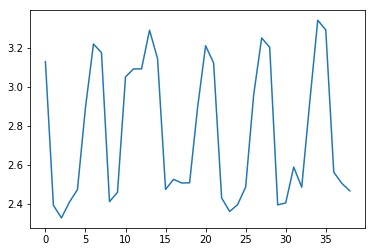

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.765309   
air_0164b9927d20bcc3_2017-04-23              1.422706   
air_0241aa3964b7f861_2017-04-23              2.375958   
air_0328696196e46f18_2017-04-23              2.168574   
air_034a3d5b40d5b1b1_2017-04-23              3.510262   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.843380  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.148329  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.761319  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.745806  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.457017

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l3_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')